100%|██████████| 170498071/170498071 [00:13<00:00, 13066584.81it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 103MB/s]


[Epoch 1, Batch 100] Loss: 2.218
[Epoch 1, Batch 200] Loss: 1.696
[Epoch 1, Batch 300] Loss: 1.554
[Epoch 1, Batch 400] Loss: 1.434
[Epoch 1, Batch 500] Loss: 1.373
[Epoch 1, Batch 600] Loss: 1.354
[Epoch 1, Batch 700] Loss: 1.300
[Epoch 2, Batch 100] Loss: 1.260
[Epoch 2, Batch 200] Loss: 1.206
[Epoch 2, Batch 300] Loss: 1.190
[Epoch 2, Batch 400] Loss: 1.182
[Epoch 2, Batch 500] Loss: 1.154
[Epoch 2, Batch 600] Loss: 1.138
[Epoch 2, Batch 700] Loss: 1.126
[Epoch 3, Batch 100] Loss: 1.074
[Epoch 3, Batch 200] Loss: 1.098
[Epoch 3, Batch 300] Loss: 1.065
[Epoch 3, Batch 400] Loss: 1.056
[Epoch 3, Batch 500] Loss: 1.057
[Epoch 3, Batch 600] Loss: 1.054
[Epoch 3, Batch 700] Loss: 1.026
[Epoch 4, Batch 100] Loss: 1.009
[Epoch 4, Batch 200] Loss: 0.997
[Epoch 4, Batch 300] Loss: 1.019
[Epoch 4, Batch 400] Loss: 0.995
[Epoch 4, Batch 500] Loss: 0.985
[Epoch 4, Batch 600] Loss: 0.970
[Epoch 4, Batch 700] Loss: 1.005
[Epoch 5, Batch 100] Loss: 0.992
[Epoch 5, Batch 200] Loss: 0.954
[Epoch 5, 

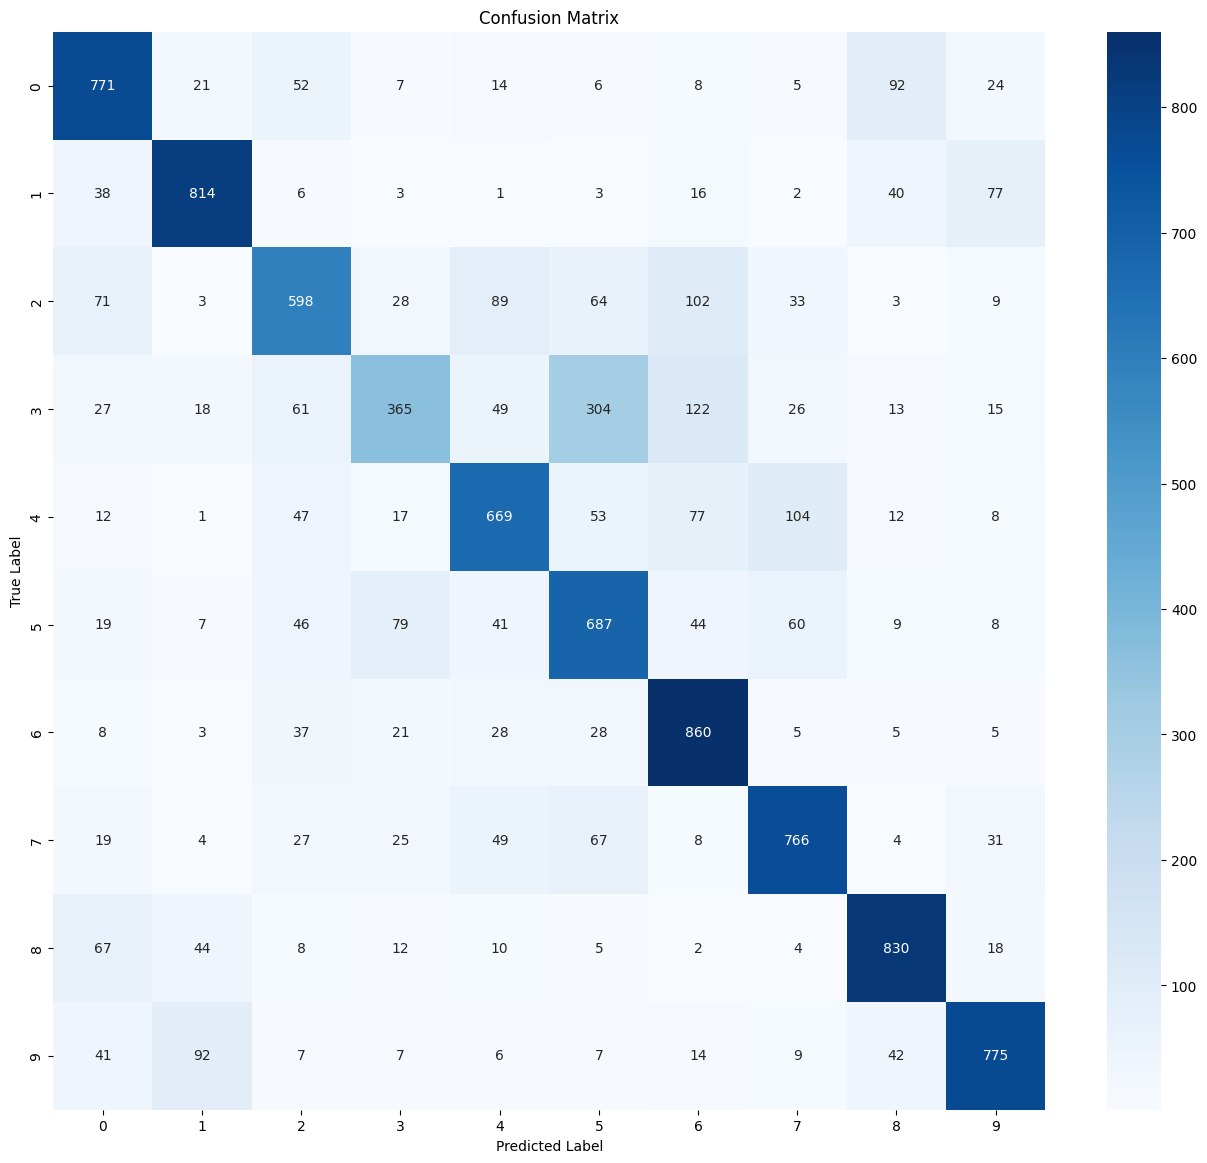

Accuracy of the network on the 10000 test images: 71.35%


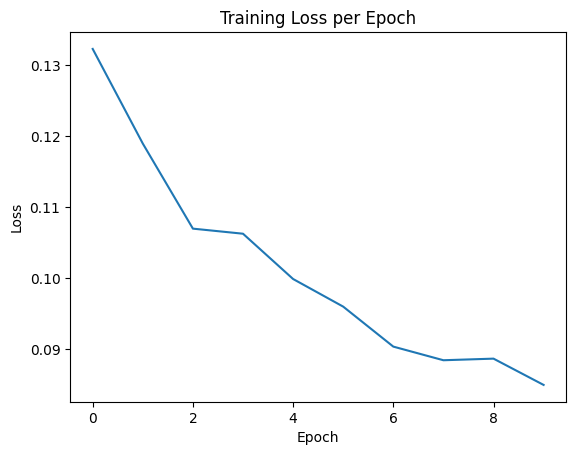

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt

# 1. Загрузка и предобработка данных с аугментацией для CIFAR-10
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Нормализация для CIFAR-10
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# 2. Загрузка MobileNet v3
model = models.mobilenet_v3_small(pretrained=True)

# Изменяем последний слой под количество классов CIFAR-10
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 10)

# 3. Инициализация устройства (GPU/CPU), функции потерь и оптимизатора
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# 4. Функция обучения модели (аналогична той, что у тебя была)
def train_model(model, trainloader, criterion, optimizer, scheduler, epochs=10):
    train_loss = []
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:  # Печать каждые 100 batch'ей
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}')
                running_loss = 0.0

        scheduler.step()
        train_loss.append(running_loss / len(trainloader))

    print('Finished Training')
    return train_loss

# 5. Обучение модели
train_loss = train_model(model, trainloader, criterion, optimizer, scheduler, epochs=10)

# 6. Тестирование модели и построение матрицы ошибок (как в ЛР №1)
test_model_with_confusion_matrix(model, testloader)

# 7. Построение графика ошибки
plt.plot(train_loss)
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
